<a href="https://colab.research.google.com/github/dash-ka/Algorithms_for_massive_datasets/blob/master/SON_frequent_itemsets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

In [1]:
!pip install pyspark
import time
import csv
import random
import pandas as pd
import numpy as np
from itertools import combinations
from collections import defaultdict
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Kaggle API
Upload a json file with your Kaggle API key.

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list # just to check everything works

Download the dataset from Kaggle and read it in pandas Data Frame.

In [ ]:
!kaggle datasets files bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows

In [ ]:
!kaggle datasets download bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows -f UkraineCombinedTweetsDeduped20220227-131611.csv.gzip 
!unzip "/content/UkraineCombinedTweetsDeduped20220227-131611.csv.gzip.zip" && rm *.zip


In [49]:
filename = r"/content/UkraineCombinedTweetsDeduped20220227-131611.csv.gzip"
tweets = pd.read_csv(filename, compression='gzip', usecols=["text","language"], encoding='utf-8', quoting=csv.QUOTE_ALL)

In [50]:
tweets.head()

,text,language
0,Footage of the airport bombing in Ivano-Franki...,en
1,12.37 น. เจมส์ วอเตอร์เฮาส์ ผู้สื่อข่าว BBC ใน...,th
2,"Die Rede von #Putin ist echt gruselig:\n""Russl...",de
3,Ukraine MP Sophia Fedyna tells about the groun...,en
4,รัสเซียยิงขีปนาวุธรัวๆไปยังยูเครน\n#รัสเซียยูเ...,th


In [51]:
print(tweets['language'].unique().tolist())

['en', 'th', 'de', 'es', 'ta', 'tr', 'lt', 'fi', 'ru', 'und', 'fr', 'ht', 'no', 'in', 'pl', 'uk', 'pt', 'ar', 'nl', 'bn', 'it', 'hi', 'iw', 'ckb', 'ur', 'mr', 'el', 'ps', 'gu', 'ml', 'ja', 'ca', 'et', 'zh', 'sv', 'fa', 'cs', 'te', 'da', 'or', 'tl', 'ro', 'ko', 'pa', 'si', 'sl', 'bg', 'kn', 'my', 'lv', 'eu', 'vi', 'hu', 'am', 'is', 'ka', 'sr', 'cy', 'ne', 'dv', 'sd', 'hy', 'km', 'lo']


Selecting tweets in English language.

In [52]:
tweets = tweets[tweets["language"]=="en"].reset_index(drop=True).text

##Tokenization

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words("english"))
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def tokenize(text):

  """
  Tokenize the tweet raw text using TweetTokenizer.
  Clean the tokens by removing @ and \#. 
  Filter out stopwords and keep strings made of alphabet characters only.

  Args:
    support: A tweet text.

  Returns:
     A list of words.

  """

  tokens = set()
  for x in tweet_tokenizer.tokenize(text):
    x = x.lstrip("[#@]").lower()
    if (x.isalpha()) and (x not in stop):
      tokens.add(x)
  return list(tokens)

In [ ]:
tweets[455].split()

In [6]:
data = sc.parallelize(list(tweets))\
          .map(tokenize)\
          .filter(lambda x:len(x)>1)\
          .collect()

In [20]:
def apriori(support):

    """
    Run A-priori algorithm over a partition of baskets
    to retrieve candidate frequent itemsets.

    Args:
      support: minimum support in percentage terms.

    Returns:
      A set of key-value pairs (tuple, 1),
      where tuple is a frequent itemset from the sample.

    """

    def search_local_candidates(partition):

      # read data
      baskets = []
      for v in partition:
        baskets.append(v)
          

      # compute adjusted threshold accounting for the partition size
      threshold = support * len(baskets) 
      w2i = {}

      # get frequent items
      Counter = defaultdict(lambda:0)
      for basket in baskets:
        for item in basket:
          if item not in w2i:
            w2i[item] = len(w2i.keys())
          Counter[w2i[item]]+=1
      i2w = {index:word for word, index in w2i.items()}
      freq_items = {i2w[idx] for idx, s in Counter.items() if s >= threshold}

      
      # initialize the output
      freq_sets = [] 
      k = 2
      # get frequent pairs
      Counter = defaultdict(lambda:0)
      for basket in baskets:
        pairs = combinations(filter(lambda x: x in freq_items, sorted(basket)), 2)
        for pair in pairs:
          pair = tuple(map(lambda token: w2i[token], pair))
          Counter[pair]+=1

      frequents = {tuple(map(lambda x :i2w[x], key)) for key, sup in Counter.items() if sup >= threshold}

      # get frequent itemsets of size > 2
      while len(frequents)!=0:
        k+=1 
        freq_sets.extend(frequents)
        previous_frequents = frequents
        Counter = defaultdict(lambda:0)
        for basket in baskets:
          if len(basket)>=k: # verify that the basket has at least k items
            candidates = combinations(filter(lambda x: x in freq_items, sorted(basket)), k)
            for candidate in candidates:
              subsets = set(combinations(filter(lambda x: x in freq_items, candidate), k-1))
              if len(subsets.intersection(set(previous_frequents)))==len(subsets):
                candidate = tuple(map(lambda token: w2i[token], candidate))
                Counter[candidate]+=1
        frequents = {tuple(map(lambda x :i2w[x], key)) for key, sup in Counter.items() if sup >= threshold}
          

      itemsets = list(map(lambda t:(t, 1), freq_sets))
      singleton = list(map(lambda t:((t,), 1), freq_items))
        
      return itemsets + singleton

    return search_local_candidates

In [10]:
def validate(candidates):

    """
    Invokes a function over a partition to
    compute the support of the candidate itemsets

    Args: 
    candidates: List of candidate itemsets
    
    Return:
    A set of key-value pairs (candidate_itemset, local_support),
    where candidate_itemset is a tuple of items.

    """

    def count_candidates(partition):
      baskets = []
      for v in partition:
        baskets.append(v)

      Counter = defaultdict(lambda:0)
      for basket in baskets:
        for candidate in candidates:
          if all(item in basket for item in candidate):
            Counter[candidate]+=1

      return Counter.items()
      
    return count_candidates 

In [18]:
class SON():

  def __init__(self, data, algorithm = apriori):
    self.algorithm = algorithm
    self.validate = validate
    self.data = sc.parallelize(data).cache()
    self.n_baskets = self.data.count()

  def freqItemsets(self, min_support):
    
    algorithm = self.algorithm
    validate = self.validate 
    n_baskets = self.n_baskets 
    data = self.data

    # PHASE_1: each partition generates a set of local candidates (frequent itemsets)
    candidates = (data.repartition(3)
                  .mapPartitions(algorithm(min_support))
                  .groupByKey()
                  .map(lambda x:x[0])
                  .collect())
    # PHASE_2: counting global support for candidate itemsets
    frequent_itemsets = (sorted(data.repartition(3)
                    .mapPartitions(validate(candidates))
                    .reduceByKey(lambda x, y: x+y)
                    .filter(lambda x: x[1]>= min_support*n_baskets)
                    .map(lambda x: (list(x[0]), x[1]) )
                    .collect(), key=lambda x: -len(x[0])))
    
    return frequent_itemsets

In [21]:
start = time.time()
model = SON(data, apriori)
son_result = model.freqItemsets(0.15) 
end = time.time()
print(end-start)

31.262086868286133


In [22]:
son_result

[(['russia', 'ukraine'], 233311),
 (['russian', 'ukraine'], 157805),
 (['ukrainian'], 110932),
 (['russia'], 290467),
 (['ukraine'], 548237),
 (['russian'], 184663),
 (['putin'], 137374)]

## FPGrowth implementation

In [28]:
# create a distributed data frame from tweets  dataset
test = spark.createDataFrame(pd.DataFrame(pd.Series(data, name="text")), ["text"]).cache()

In [30]:
test.take(5)

[Row(text=['airport', 'footage', 'russia', 'bombing', 'ukraine']),
 Row(text=['fedyna', 'tells', 'kharkiv', 'exclusive', 'ground', 'situation', 'mp', 'kyiv', 'itvideo', 'russia', 'conversation', 'sophia', 'ukraine']),
 Row(text=['missile', 'cruise', 'fell', 'fired', 'kiev', 'russia', 'ukraine', 'army', 'russian']),
 Row(text=['share', 'spread', 'russia', 'help', 'ukraine']),
 Row(text=['airport', 'footage', 'russia', 'bombing', 'ukraine'])]

In [31]:
from pyspark.ml.fpm import FPGrowth
fpGrowth = FPGrowth(itemsCol="text", minSupport = 0.15)
model = fpGrowth.fit(test)
fp_results = model.freqItemsets.collect()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [45]:
fp_result = [(item[0], item[1]) for item in sorted(fp_results, key = lambda x:-len(x[0]))]

In [46]:
fp_result

[(['russian', 'ukraine'], 157805),
 (['russia', 'ukraine'], 233311),
 (['russian'], 184663),
 (['ukrainian'], 110932),
 (['ukraine'], 548237),
 (['russia'], 290467),
 (['putin'], 137374)]

## Scale-up experiments.


In [13]:
size = np.arange(100000, 700001, step=100000)
elapsed_time = dict()
for i in size:
  sample = random.sample(data, i)
  model = SON(sample)

  start = time.time()
  model.freqItemsets(0.1) 
  end = time.time()
  elapsed_time[i] = end - start
  print(elapsed_time[i])

12.782711744308472
21.110293865203857
29.373741388320923
39.728447914123535
48.82483220100403
54.47564768791199


In [13]:
supp = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]

support_time = dict()
model = SON(data)
for p in supp:
  start = time.time()
  model.freqItemsets(p)  
  end = time.time()
  support_time[p] = end - start
  print(support_time[p])

93.34163975715637
81.90585660934448
72.08873248100281
89.38303422927856
72.18801426887512
66.6675283908844


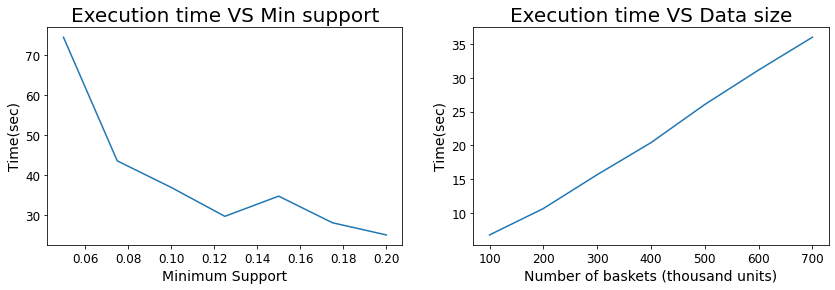

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(1, 2,figsize = (14,4))
axes[0].plot(list(support_time.keys()), list(support_time.values()))
axes[0].set_title("Execution time VS Min support", fontsize = 20)
axes[0].set_xlabel("Minimum Support", fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].set_ylabel("Time(sec)", fontsize=14)

axes[1].plot(list(elapsed_time.keys()), list(elapsed_time.values()))
axes[1].set_title("Execution time VS Data size", fontsize = 20)
axes[1].set_xlabel("Number of baskets (thousand units)", fontsize=14)
axes[1].set_xticks(np.arange(100000, 700001, step=100000))
axes[1].set_xticklabels(['100','200','300','400', '500','600','700'])
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].set_ylabel("Time(sec)", fontsize=14)
plt.savefig('scale.png')